In [1]:
using Plots
using LaTeXStrings
using MIRT: jim

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling MIRT [7035ae7a-3787-11e9-139a-5545ed3dc201]
└ @ Base loading.jl:1278


### Setup the problem

In [2]:
dx = 1
dy = sqrt(3)/3 * dx
N = 256
xC = LinRange(-2*dx, 2*dx, N)
yC = LinRange(0, 3*dy, N)

# Useful functions
function hexagon(h, k, dx, dy)
# Returns vertices of the hexagon
    X = [-dx/3, dx/3, 2/3*dx, dx/3, -dx/3, -2/3*dx, -dx/3] 
    Y = [   dy,   dy,      0,  -dy,   -dy,       0,    dy]
    return h .+ X, k .+ Y
end

function hexagonFlats(h, k, dx, dy)
# Returns midpoinhts of the flat sides
    X = [ 0, dx/2,  dx/2,   0, -dx/2, -dx/2]
    Y = [dy, dy/2, -dy/2, -dy, -dy/2,  dy/2]
    return h .+ X, k .+ Y
end

hexagonFlats (generic function with 1 method)

### Plot the sampling grid

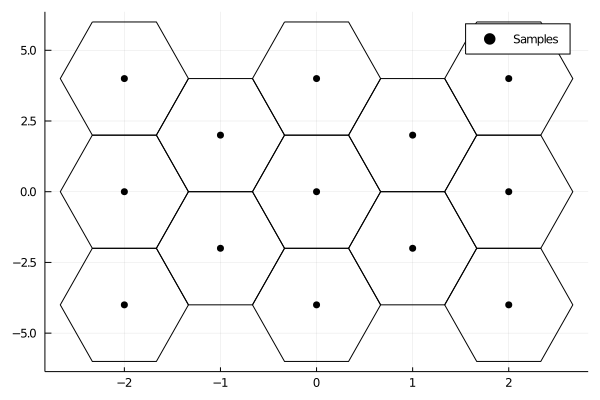

In [42]:
M = 2
N = 2
S = Array{Float64}(undef, 0, 2)
for m = -M:M
    for n = -N:N
        if iseven(m+n)
            S = cat(S, [m*dx n*dy]; dims = 1)
        end
    end
end

scatter(S[:, 1], S[:, 2], c = :black, label = "Samples")
plot!(hexagon.(S[:, 1], S[:,2], dx, dy), label = :none, c = :black)
# scatter!(hexagon(0, 0, dx, dy), c = :red, label = "h = 1/3")
# scatter!(hexagonFlats(0, 0, dx, dy), c = :gold, label = "h = 1/2")

In [43]:
savefig("hex_sampling_alt.pdf")

### Define the interpolation kernel

In [13]:
function h(x, y, dx, dy)
    # Get angle in QI (and use symmetry)
    y = abs(y)
    x = abs(x)
    θ = atan(y, x)
    # East 
    if (θ <= atan(dy, dx)) 
        tmp = 1 - x/(dx) 
    # North-East
    else
        tmp = 1 - x/(2*dx) - y/(2*dy)
    end
    return max(tmp, 0)
end;

In [6]:
# This version only works when dy = sqrt(3)/3*dx !
function h_alt(x, y, dx, dy)
    # Get angle
    θ = atan(y, x)  
    r  = hypot(x, y)
    x  = r*(cos(mod(θ+π/6, π/3) - π/6))
    max(1 - x/dx, 0)
end;

### Test the kernel

In [14]:
F  = hexagonFlats(0, 0, dx, dy)
xF = F[1] # x coordinate of flat midpoints
yF = F[2] # y ...
V  = hexagon(0, 0, dx, dy)
xV = V[1] # x coordinate of vertices
yV = V[2] # y ...
@assert h(0, 0, dx, dy)   ≈ 1.0
@assert h(dx, dy, dx, dy) ≈ 0.0
@assert h(0 , 2*dy, dx, dy) ≈ 0.0
# Each vertex should have h = 1/3
@assert all(h.(xV, yV, dx, dy) .≈ 1/3)
# Each midpoint should be half
@assert all(h.(xF, yF, dx, dy) .≈ 1/2)

### Plot the kernel

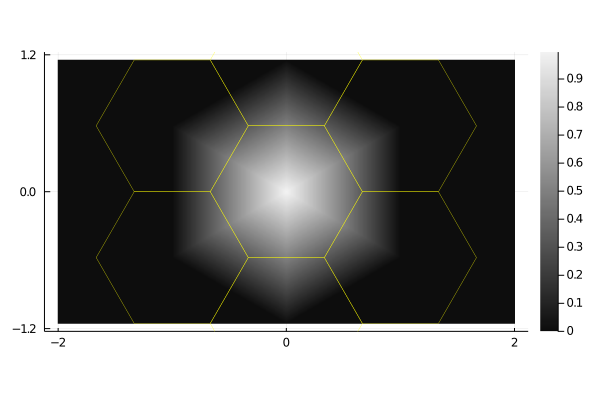

In [15]:
N = 512
xC = LinRange(-2*dx, 2*dx, N)
yC = LinRange(-2*dy, 2*dy, N)
jim(xC, yC, h.(xC, yC', dx, dy), yflip = false)
plot!(xlim =[-2dx, 2dx], ylim = [-2dy, 2dy])
# Superimpose some hexagons
plot!(hexagon.(S[:, 1], S[:,2], dx, dy), label = :none, c = :yellow, lw = .3)

In [9]:
savefig("kernel.pdf")

### Demonstrate partion of unity

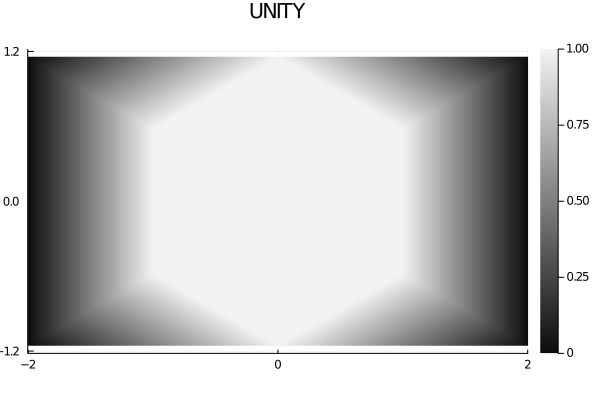

In [12]:
hUnity= h.(xC, yC', dx, dy) + 
    h.(xC .+ dx, yC' .+ dy, dx, dy) +
    h.(xC .- dx, yC' .+ dy, dx, dy) +
    h.(xC .+  0, yC' .+ 2dy, dx, dy) +
    h.(xC .+  0, yC' .- 2dy, dx, dy) +
    h.(xC .+ dx, yC' .- dy, dx, dy) +
    h.(xC .- dx, yC' .- dy, dx, dy) 
 
jim(xC, yC, hUnity , yflip = false, title = "UNITY")

In [11]:
savefig("unity.pdf")

### Stretching

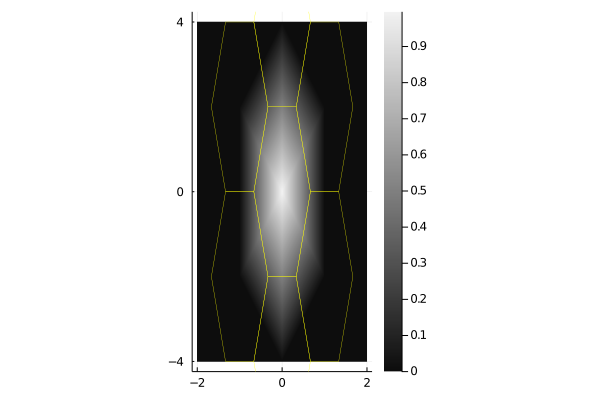

In [40]:
N = 512
dx = 1
dy = 2
xC = LinRange(-2*dx, 2*dx, N)
yC = LinRange(-2*dy, 2*dy, N)
jim(xC, yC, h.(xC, yC', dx, dy), yflip = false)

# Superimpose some hexagons
M = 1
N = 2
S = Array{Float64}(undef, 0, 2)
for m = -M:M
    for n = -N:N
        if iseven(m+n)
            S = cat(S, [m*dx n*dy]; dims = 1)
        end
    end
end
plot!(hexagon.(S[:, 1], S[:,2], dx, dy), label = :none, c = :yellow, lw = .3)
plot!(xlim =[-2dx, 2dx], ylim = [-2dy, 2dy], aspect_ratio = 1.0)

In [41]:
savefig("tall_kern.pdf")